In [859]:
import os
import datetime
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

<module 'Tracking_Visuals' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Visuals.py'>

In [2]:
# config
current_dir = os.path.dirname(os.getcwd())
dir_path = os.path.join(current_dir, 'Aalborg_Jeff') # path to directory of Tracab data
LEAGUE = 'DSL'

# Read data

In [705]:
# config
fname = '984455'
match_id = fname

# # example
# player = team0_players[14]

In [706]:
# read
fpath = os.path.join(dir_path, fname, fname + '_TracDAT')
print(fpath)
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(LEAGUE, fpath, fname, verbose=True)

/Users/jeffbalkanski/research_soccer/Aalborg_Jeff/984455/984455_TracDAT
Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [28]
away goalkeeper(s):  [1]
0 70642
70643 142733


# Positions

In [707]:
# positions
player_id_to_name = pd.read_csv('../playerid_jerseynum_map.csv')
player_id_to_name = player_id_to_name[player_id_to_name['Match ID'] == int(match_id)]

In [708]:
player_id_to_name['Starting Position'].unique()

array(['GK', 'LFB', 'RFB', 'CD', 'CM', 'LM', 'RM', 'FW', 'Sub'],
      dtype=object)

In [709]:
# map player id and jersey num
def map_playerids_positions(team1_players, team0_players, match_id, loc_mapping='../playerid_jerseynum_map.csv'):
    mapping = pd.read_csv(loc_mapping)
    player_id_to_name = mapping[mapping['Match ID'] == int(match_id)]
    all_players_pre = [(x[0], x[1], 1) for x in team1_players.items()] + [(x[0], x[1], 0) for x in team0_players.items()]
    all_players = []
    for num, player, team in all_players_pre:
        team_str = 'Home' if team else 'Away'
        player_id = None
        players_team = player_id_to_name[player_id_to_name['Team'] == team_str]
        player_id, starting_pos = players_team[players_team['Jersey Num'] == num][['Playerid', 'Starting Position']].values[0]
        all_players.append([player_id, team, num, starting_pos, player])
        
    # get rid of non starters
    all_players = pd.DataFrame(all_players, columns=['player_id', 'Team', 'jersey_num', 'start_pos', 'obj'])
    all_players = all_players[all_players['start_pos'] != 'Sub']

    return all_players

# get mapping
all_players = map_playerids_positions(team1_players, team0_players, match_id)

## Add main positions -> F, M, D

In [710]:
# main positions for averages
main_positions = {
    'F': ['FW'],
    'M': ['CM', 'LM', 'RM', 'DM', 'CDM', 'LCM', 'RCM', 'AM', 'ACM', 'LAM', 'CAM', 'RAM'],
    'D': ['CD', 'RWB', 'LWB', 'RFB', 'LFB'],
    'GK': ['GK'],
    'Sub': ['Sub']
}

main_positions_inv = {}
for k, positions in main_positions.items():
    for pos in positions:
        main_positions_inv[pos] = k

all_players['start_pos_super'] = all_players['start_pos'].apply(lambda x: main_positions_inv[x])

# Players, time on the field, find subs

In [711]:
# count frames for players
players_in_frames = defaultdict(int)
for f in frames_tb:
    for num in f.team1_jersey_nums_in_frame:
        players_in_frames[(1, num)] += 1
    for num in f.team0_jersey_nums_in_frame:
        players_in_frames[(0, num)] += 1

In [712]:
# find who is on the field
player_times = []
for (team, num), n_frames in players_in_frames.items():
    player_times.append([team, num, n_frames/25/60])
    
player_time_df = pd.DataFrame(player_times, columns=['Team', 'jersey_num', 'time_played'])

# merge back with player data
all_players_w_time = pd.merge(player_time_df, all_players, on=['Team', 'jersey_num'])

### filter out players who do not play full game

In [713]:
players_full_game = all_players_w_time[all_players_w_time['time_played'] > 90]

In [714]:
players_full_game.groupby('start_pos').count()['player_id']

start_pos
CD     4
CM     2
FW     3
GK     2
LFB    2
LM     1
RFB    2
RM     1
Name: player_id, dtype: int64

# Add Energy Expenditure

In [717]:
import Tracking_Fatigue as fatigue
importlib.reload(fatigue)

# # add energy expenditure
# helpers.add_metric_to_player(team1_players, team0_players, fatigue.get_energy_expenditure, 'energy_x', skip_end=1)

<module 'Tracking_Fatigue' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Fatigue.py'>

In [373]:
# get series
EX_1_2 = helpers.get_all_values(team1_players[2], 'energy_x', start=1, skip_last=1)
plt.plot(EX_1_2)

# example
EX_1_10 = fatigue.get_energy_expenditure(team1_players[10])
plt.plot(np.cumsum(EX_1_10))

# Get Energy expenditure Per position
> `EX_all`

> `EX_df` as a dataframe

In [860]:
# get all values
metric_values = []
for row in players_full_game.to_dict(orient='records'):
    player = row['obj']
    print(player, row['Team'], row['jersey_num'])
    val_array = fatigue.get_energy_expenditure(player)
    print()
    metric_values.append([row['Team'], row['jersey_num'], row['start_pos'], row['start_pos_super'], val_array])
    
EX_all = np.array(metric_values)

<Tracab.tracab_player object at 0x1d5acfe550> 1 27
<Tracab.tracab_player object at 0x1d5acfe410> 1 30
<Tracab.tracab_player object at 0x1d5acfefd0> 1 10
<Tracab.tracab_player object at 0x1d5acfe790> 1 5
<Tracab.tracab_player object at 0x1d187f54d0> 1 3
<Tracab.tracab_player object at 0x1d5acfe810> 1 8
<Tracab.tracab_player object at 0x1d5acfec50> 1 28
<Tracab.tracab_player object at 0x1cf1a50150> 1 2
<Tracab.tracab_player object at 0x1d5acfe1d0> 1 18
<Tracab.tracab_player object at 0x1d5acfee10> 0 3
<Tracab.tracab_player object at 0x1d5acfe850> 0 17
<Tracab.tracab_player object at 0x1d5acfe390> 0 16
<Tracab.tracab_player object at 0x1d5acfe9d0> 0 6
<Tracab.tracab_player object at 0x1d5acfe450> 0 1
<Tracab.tracab_player object at 0x1d5acfef50> 0 4
<Tracab.tracab_player object at 0x1d5acfe490> 0 9
<Tracab.tracab_player object at 0x1d5acfe950> 0 5


In [862]:
build_df = []
n = len(EX_all[0][4])
for team, num, pos_detail, pos, vals_x in EX_all:
    build_df.append(np.append(np.array([team, num, pos_detail, pos]), vals_x))

# as a dataframe
EX_df = pd.DataFrame(build_df, columns=['team', 'num', 'pos_detail', 'pos'] + list(range(n)))

In [718]:
# all cumulative
cumul_EX_per_pos = [(x[:3], np.cumsum(x[4])) for x in metric_values]

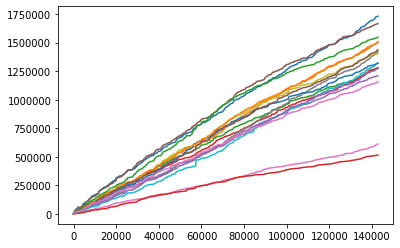

In [719]:
# plot all
for pos, vals in cumul_EX_per_pos:
    plt.plot(vals)
    plt.plot()

# Get energy expenditure per position

## Total energy expanded per player

In [720]:
total_energy_per_player = list(map(lambda row: [row[0], row[1], row[3], sum(row[4])], EX_all))

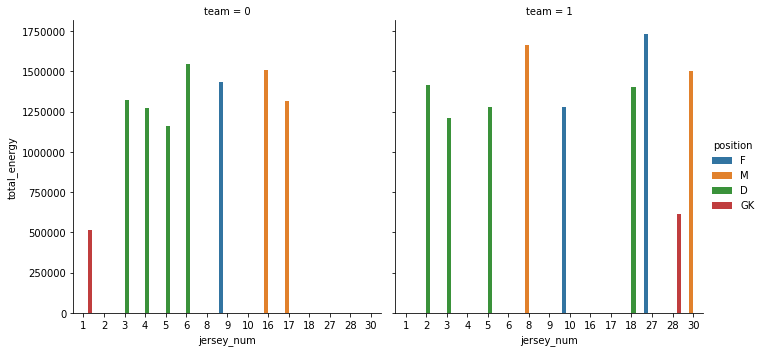

In [721]:
sns.catplot(
    data=pd.DataFrame(data=total_energy_per_player, columns=['team', 'jersey_num', 'position', 'total_energy']),
    x='jersey_num', y='total_energy', hue='position',
    col='team', kind='bar', height=5,
)

plt.show('Bar plot of t')
plt.show()

## Total distance per position

In [1041]:
players_full_game

,Team,jersey_num,time_played,player_id,start_pos,obj,start_pos_super
0,1,27,95.156667,60638,FW,<Tracab.tracab_player object at 0x1d5acfe550>,F
1,1,30,95.156667,68761,CM,<Tracab.tracab_player object at 0x1d5acfe410>,M
2,1,10,95.156667,111282,FW,<Tracab.tracab_player object at 0x1d5acfefd0>,F
3,1,5,95.156667,56317,CD,<Tracab.tracab_player object at 0x1d5acfe790>,D
4,1,3,95.156667,52560,CD,<Tracab.tracab_player object at 0x1d187f54d0>,D
5,1,8,95.156667,212394,LM,<Tracab.tracab_player object at 0x1d5acfe810>,M
6,1,28,95.156667,50310,GK,<Tracab.tracab_player object at 0x1d5acfec50>,GK
8,1,2,95.156667,207273,RFB,<Tracab.tracab_player object at 0x1cf1a50150>,D
9,1,18,95.156667,247047,LFB,<Tracab.tracab_player object at 0x1d5acfe1d0>,D
11,0,3,95.156667,79462,LFB,<Tracab.tracab_player object at 0x1d5acfee10>,D


In [1047]:
# get all values
distance_values = []
for row in players_full_game.to_dict(orient='records'):
    player = row['obj']
    val_array = np.sum(fatigue.get_distance_btw_frames(player))
    distance_values.append([row['Team'], row['jersey_num'], row['start_pos'], row['start_pos_super'], val_array])
    
distance_all = np.array(distance_values)

In [1074]:
mean_dist_per_pos = []
for position in ['F', 'M', 'D', 'GK']:
    total_dist_for_pos = [(pos, float(vals)) for (team, num, _, pos, vals) in distance_all if pos == position]
    mean_dist_per_pos.append((position, np.mean([x for _, x in total_dist_for_pos])))

In [1075]:
mean_dist_per_pos

[('F', 11223.666666666666),
 ('M', 11729.25),
 ('D', 10710.715000000002),
 ('GK', 5612.275000000001)]

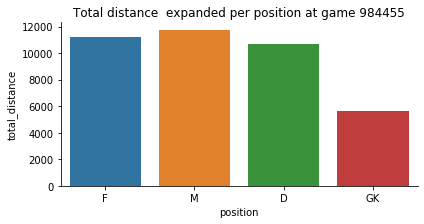

In [1079]:
data_total_d = pd.DataFrame(mean_dist_per_pos, columns=['position', 'total_distance'])
sns.catplot(x='position', y='total_distance', data=data_total_d, kind='bar', height=3, aspect=2)
plt.title('Total distance  expanded per position at game {}'.format(match_id))
plt.show()

## Total energy expanded per position

In [722]:
EX_all[0]

array([1, 27, 'FW', 'F',
       array([7.56299997, 7.07788846, 6.9129645 , ..., 3.67626652, 2.97328458,
       2.40943142])], dtype=object)

In [723]:
total_E_per_pos = []
for position in ['F', 'M', 'D', 'GK']:
    total_for_pos = [(pos, np.sum(vals)) for (team, num, _, pos, vals) in EX_all if pos == position]
    total_E_per_pos.append((position, np.mean([x for _, x in total_for_pos])))

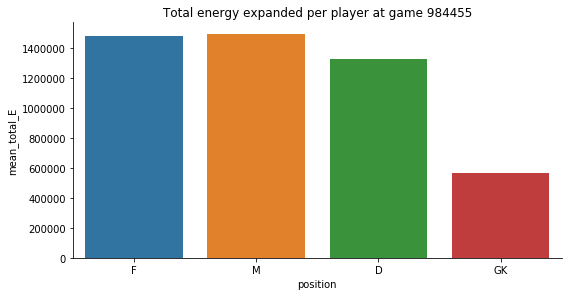

In [1040]:
data_total_E = pd.DataFrame(total_E_per_pos, columns=['position', 'mean_total_E'])
sns.catplot(x='position', y='mean_total_E', data=data_total_E, kind='bar', height=4, aspect=2)
plt.title('Total energy expanded per player at game {}'.format(match_id))
plt.show()

## Mean energy expanded per position

In [725]:
EX_all[0]

array([1, 27, 'FW', 'F',
       array([7.56299997, 7.07788846, 6.9129645 , ..., 3.67626652, 2.97328458,
       2.40943142])], dtype=object)

In [735]:
mean_E_per_pos = []
for position in ['F', 'M', 'D', 'GK']:
    mean_for_pos = np.array([(row[3], row[4]) for row in EX_all if row[3] == position])
    mean_pos = np.mean([player[1] for player in mean_for_pos], axis=0)
    mean_E_per_pos.append([position, np.cumsum(mean_pos)])

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


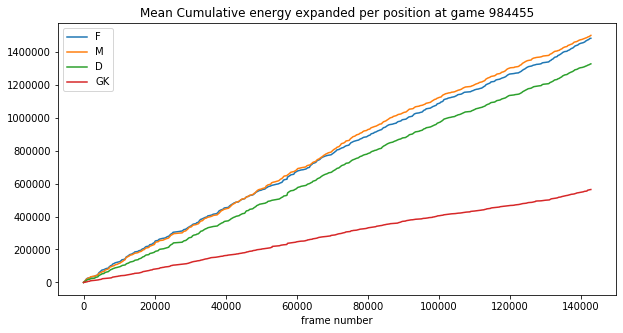

In [736]:
fig, ax = plt.subplots(figsize=(10, 5))
for pos, vals in mean_E_per_pos:
    ax.plot(vals, label=pos)
    
plt.title('Mean Cumulative energy expanded per position at game {}'.format(match_id))
plt.legend()
plt.xlabel('frame number')
plt.savefig('./figures/cumul_E_per_pos_game_{}'.format(match_id))
plt.show()

# Derivative of energy expanded
## Linear fit and difference

In [737]:
mean_E_per_pos

[['F', array([9.78779658e+00, 1.79879220e+01, 2.47082646e+01, ...,
         1.48136034e+06, 1.48136326e+06, 1.48136624e+06])],
 ['M', array([1.90138056e+00, 3.82884505e+00, 5.83814874e+00, ...,
         1.49923022e+06, 1.49924624e+06, 1.49926697e+06])],
 ['D', array([9.77836996e-01, 1.70402214e+00, 2.22820415e+00, ...,
         1.32657809e+06, 1.32658165e+06, 1.32658520e+06])],
 ['GK', array([1.83127742e+00, 3.63576645e+00, 5.42064128e+00, ...,
         5.63841413e+05, 5.63847534e+05, 5.63853607e+05])]]

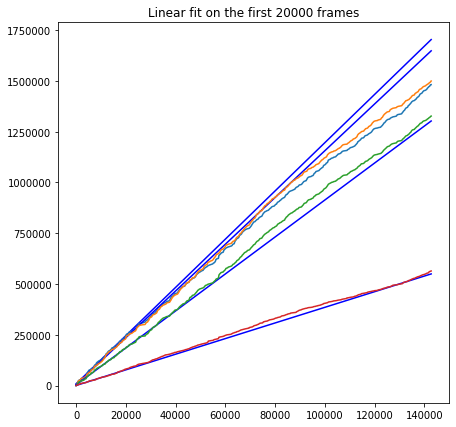

In [1083]:
first_k = 20000
linear = {'ratio': [], 'error': []}
ax = plt.subplots(figsize=(7, 7))
for pos, series in mean_E_per_pos:
    series_small = series[:first_k]
    xs_small, xs = np.array(range(len(series_small))), np.array(range(len(series)))
    slope, intercept = np.polyfit(xs_small, series_small, 1)

    # error
    linear_extended = xs*slope + intercept
    linear['error'].append((pos, linear_extended - series))
    linear['ratio'].append((pos, np.divide(linear_extended, series)))
    a = np.divide(linear_extended, series)

    # plot
    
    plt.plot(xs, linear_extended, 'b')
    plt.plot(series)
    

plt.title('Linear fit on the first {} frames'.format(first_k))
plt.show()

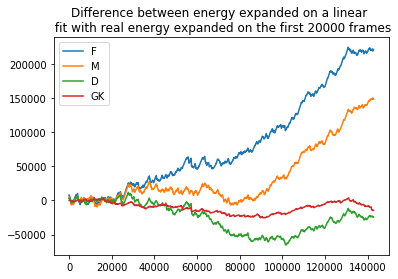

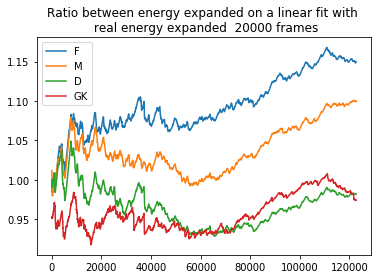

In [1027]:
for pos, error in linear['error']:
    plt.plot(error, label=pos)
plt.title('Difference between energy expanded on a linear \n fit with real energy expanded on the first 20000 frames')
plt.legend()
plt.show()

for pos, error in linear['ratio']:
    plt.plot(error[20000:], label=pos)
plt.title('Ratio between energy expanded on a linear fit with \n real energy expanded  20000 frames')
plt.legend()
plt.show()

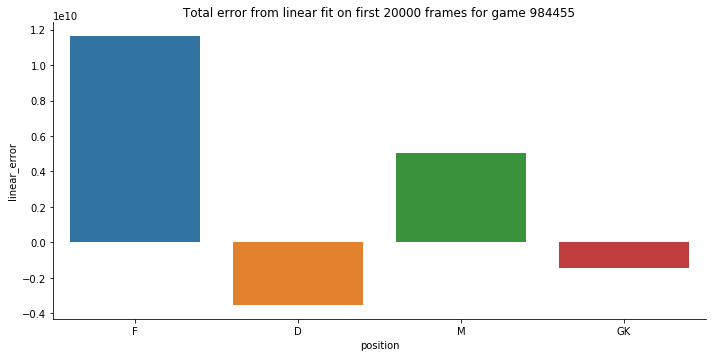

In [741]:
data_linear_error = pd.DataFrame([(pos, sum(errors)) for (pos, errors) in errors_linear], columns=['position', 'linear_error'])
sns.catplot(x='position', y='linear_error', data=data_linear_error, 
            kind='bar', height=5, aspect=2)
plt.title('Total error from linear fit on first 20000 frames for game {}'.format(match_id))
plt.show()

## 2nd degree free fit 

In [742]:
mean_E_per_pos

[['F', array([9.78779658e+00, 1.79879220e+01, 2.47082646e+01, ...,
         1.48136034e+06, 1.48136326e+06, 1.48136624e+06])],
 ['M', array([1.90138056e+00, 3.82884505e+00, 5.83814874e+00, ...,
         1.49923022e+06, 1.49924624e+06, 1.49926697e+06])],
 ['D', array([9.77836996e-01, 1.70402214e+00, 2.22820415e+00, ...,
         1.32657809e+06, 1.32658165e+06, 1.32658520e+06])],
 ['GK', array([1.83127742e+00, 3.63576645e+00, 5.42064128e+00, ...,
         5.63841413e+05, 5.63847534e+05, 5.63853607e+05])]]

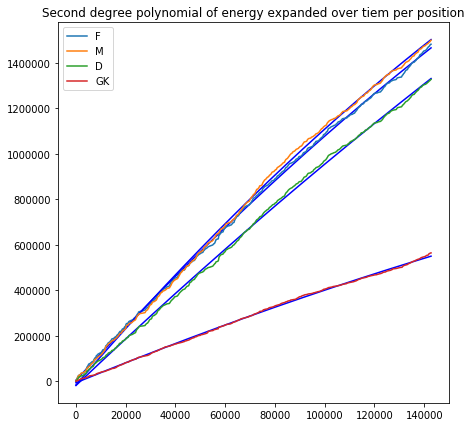

In [1092]:
# 2nd degree fit
errors_2nd_deg = []
fig, ax = plt.subplots(figsize=(7, 7))
for pos, series in mean_E_per_pos:
    xs = np.array(range(len(series)))
    a, b, c = np.polyfit(xs, series, 2)

    # error
    poly_fit_2 = a*np.power(xs, 2) + b*xs + c
    error = poly_fit_2 - series
    errors_2nd_deg.append((pos, a, b, c, poly_fit_2, sum(error)))

    # plot
    
    ax.plot(xs, poly_fit_2, 'b')
    ax.plot(series, label=pos)
plt.title('Second degree polynomial of energy expanded over tiem per position'.format(first_k, pos))
plt.legend()
plt.show()

In [825]:
[(pos, error) for (pos, a, b, c, poly_fit_2, error) in errors_2nd_deg]

[('F', 1.8753111362457275e-05),
 ('M', -0.00011087721213698387),
 ('D', -1.7232028767466545e-05),
 ('GK', 1.3579614460468292e-05)]

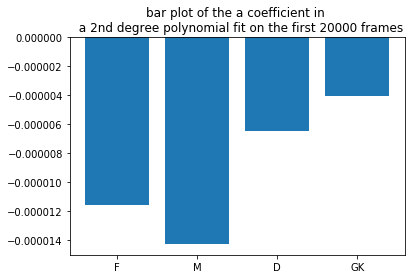

In [744]:
plt.bar(x=[x[0] for x in errors_2nd_deg], height=[x[1] for x in errors_2nd_deg])
plt.title('bar plot of the a coefficient in \n  a 2nd degree polynomial fit on the first {} frames'.format(first_k))
plt.show()

### Derivative of 2nd degree polynomial

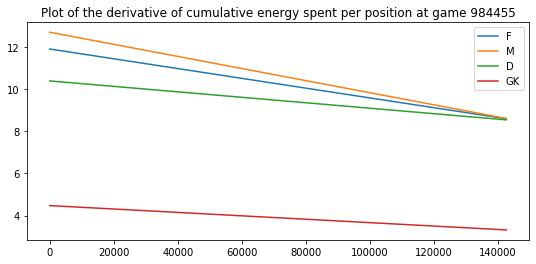

In [818]:
fig, ax = plt.subplots(figsize=(9, 4))
for pos, a, b, c, poly_fit_2 in errors_2nd_deg:
    n_frames = len(poly_fit_2)
    p2 = np.poly1d([a, b, c])
    derivative = np.polyder(p2)
    
    x = np.arange(n_frames)
    y = derivative[1] * x + derivative[0]
    ax.plot(x, y, label=pos)

    
plt.title('Plot of the derivative of cumulative energy spent per position at game {}'.format(match_id))
plt.legend()
plt.show()

# Possession: Energy consumption with or without the ball
Home team is __team 1__

In [968]:
# compute energy in possession or not
energy_in_possession = []
for team, num, pos_detail, pos, vals in EX_all:    
    pre_filter = in_possession[1:-1]
    opposed = {1: 'H', 0: 'A'}
    
    side, opp = ('H', 'A') if team == 1 else ('A', 'H') 
    print(side, opp)
    ex_in_pos = vals[np.where(pre_filter == side)]
    ex_not = vals[np.where(pre_filter == opp)]
        
    # save data
    energy_in_possession.append([team, num, pos_detail, pos, sum(ex_in_pos), sum(ex_not)])

H A
H A
H A
H A
H A
H A
H A
H A
H A
A H
A H
A H
A H
A H
A H
A H
A H


In [1022]:
df_poss = pd.DataFrame(energy_in_possession, 
                       columns=['team', 'num', 'detail_pos', 'position', 'in_possession', 'not_in_possession'])
df_poss = df_poss.groupby('position').sum()[['in_possession', 'not_in_possession']]\
                                     .stack().reset_index().rename({'level_1': 'possession', 0:'total_energy'}, axis=1)

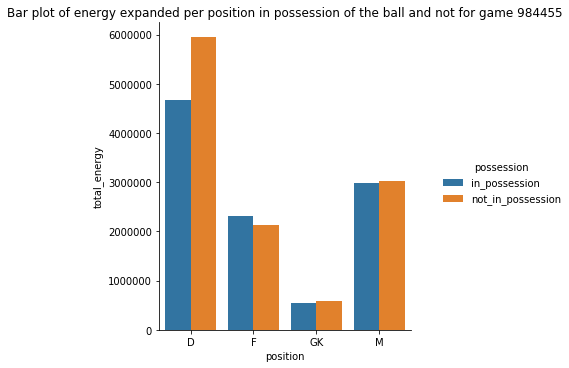

In [1098]:
sns.catplot(
    data=df_poss,
    x='position', y='total_energy', hue='possession',
    kind='bar', height=5, aspect=1
)

plt.title('Bar plot of energy expanded per position in possession of the ball and not for game {}'.format(match_id))
plt.show()

In [1002]:
df_poss

,position,level_1,0
0,D,EX_in_possession,4.661660e+06
1,D,EX_notin_possession,5.951022e+06
2,F,EX_in_possession,2.323064e+06
3,F,EX_notin_possession,2.121035e+06
4,GK,EX_in_possession,5.443379e+05
5,GK,EX_notin_possession,5.833693e+05
6,M,EX_in_possession,2.975287e+06
7,M,EX_notin_possession,3.021781e+06


# Split by half time and analyze before after